In [1]:
# packages
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

In [2]:
# directories
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"

## Load File

In [3]:
# load list of cities
list_of_cities = pd.read_csv(os.path.join(INDIR, FILE_cities), sep=';')
cities = [unidecode.unidecode(city) for city in list_of_cities.Mua_en]
df_cities = pd.DataFrame(cities, columns = ["city"])

In [4]:
# load file
file_name = "edges.csv"
fp = os.path.join(OUTDIR, file_name)
df = pd.read_csv(fp, sep=';')

In [5]:
df.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,CEAST,SOUTH,WEST,NORTH,col_en,col_fr,col_prop_fr,col_prop_en,fr_en_prop,en_fr_prop
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,0,0,1,0,21874.0,10733.0,1.787238,2.095814,0.852766,1.172655
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,0,1,1,0,3394.0,2404.0,0.400309,0.325189,1.231004,0.812345
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0,0,1,0,7899.0,4723.0,0.786465,0.756827,1.039161,0.962315
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,0,1,1,0,3342.0,2713.0,0.451763,0.320207,1.410848,0.708794
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,0,1,1,0,2397.0,1696.0,0.282415,0.229664,1.229687,0.813215


## Spread of the difference

In [6]:
df['fr_en_prop'].std()

1.98933698836733

<AxesSubplot:ylabel='Frequency'>

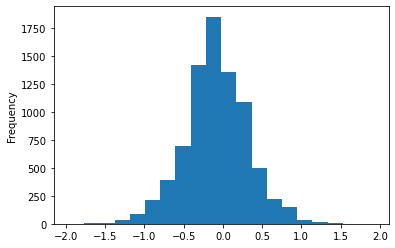

In [7]:
# distribution of the difference (log transform because proportions so .1-1-10 should be the same distance.)
# negative values french smaller than english, positive values english larger than french.
logged = np.log10(df.fr_en_prop)
logged.plot.hist(bins=20)

## Centrality

In [8]:
# degree centrality
en_degrees = dict()

for city in cities: 
    en_degrees[city] = 0

In [9]:
fr_degrees = en_degrees.copy()

In [10]:
for i, row in df.iterrows():
    en_degrees[row.city_A] += row.col_en
    en_degrees[row.city_B] += row.col_en
    fr_degrees[row.city_A] += row.col_fr
    fr_degrees[row.city_B] += row.col_fr

In [11]:
df_cities['en_degree'] = en_degrees.values()

In [12]:
df_cities['fr_degree'] = fr_degrees.values()

In [13]:
df_cities.sort_values('en_degree', ascending=False).head(10)

,city,en_degree,fr_degree
1,London,186465.0,49256.0
0,Paris,133309.0,143169.0
3,Berlin,86900.0,38242.0
7,Rome,59845.0,41235.0
12,Manchester,58871.0,8967.0
18,Vienna,54418.0,30030.0
19,Munich,44475.0,21052.0
31,Liverpool,42271.0,6478.0
4,Milan,40714.0,26289.0
2,Madrid,40176.0,22625.0


In [15]:
# proportional degree
en_degrees = dict()

for city in cities: 
    en_degrees[city] = 0

In [16]:
fr_degrees = en_degrees.copy()

In [17]:
for i, row in df.iterrows():
    en_degrees[row.city_A] += row.col_prop_en
    en_degrees[row.city_B] += row.col_prop_en
    fr_degrees[row.city_A] += row.col_prop_fr
    fr_degrees[row.city_B] += row.col_prop_fr

In [18]:
df_cities['en_deg_prop'] = en_degrees.values()

In [19]:
df_cities['fr_deg_prop'] = fr_degrees.values()

In [20]:
df_cities.head()

,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop
0,Paris,133309.0,143169.0,12.772737,23.840223
1,London,186465.0,49256.0,17.865773,8.202013
2,Madrid,40176.0,22625.0,3.849383,3.767471
3,Berlin,86900.0,38242.0,8.326151,6.367983
4,Milan,40714.0,26289.0,3.900931,4.377593


In [21]:
df_cities.sort_values('fr_deg_prop', ascending=False).head(30)


,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop
0,Paris,133309.0,143169.0,12.772737,23.840223
1,London,186465.0,49256.0,17.865773,8.202013
29,Lyon,15562.0,41878.0,1.491042,6.973443
7,Rome,59845.0,41235.0,5.733930,6.866372
3,Berlin,86900.0,38242.0,8.326151,6.367983
42,Marseille,11344.0,32188.0,1.086903,5.359883
18,Vienna,54418.0,30030.0,5.213952,5.000537
20,Brussels,29139.0,29125.0,2.791895,4.849838
4,Milan,40714.0,26289.0,3.900931,4.377593
62,Bordeaux,9714.0,25724.0,0.930728,4.283510


In [22]:
df_cities.sort_values('fr_deg_prop', ascending=True).head(15)

,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop
137,Busto Arsizio,89.0,61.0,0.008527,0.010158
118,Las Palmas,1618.0,67.0,0.155025,0.011157
120,Castellammare di Stabia-Torre Annunziata,204.0,146.0,0.019546,0.024312
122,Santa Cruz de Tenerife,577.0,180.0,0.055284,0.029973
133,Galati,1053.0,287.0,0.100891,0.047791
144,Caserta,720.0,328.0,0.068985,0.054618
126,Plovdiv,1844.0,359.0,0.176679,0.059780
119,Constanta,1409.0,391.0,0.135001,0.065109
146,Brasov,1628.0,392.0,0.155984,0.065275
143,Craiova,1532.0,396.0,0.146786,0.065941


In [23]:
df_cities.head(20)

,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop
0,Paris,133309.0,143169.0,12.772737,23.840223
1,London,186465.0,49256.0,17.865773,8.202013
2,Madrid,40176.0,22625.0,3.849383,3.767471
3,Berlin,86900.0,38242.0,8.326151,6.367983
4,Milan,40714.0,26289.0,3.900931,4.377593
5,Barcelona,32263.0,18822.0,3.091215,3.134203
6,Athens,14858.0,6952.0,1.423590,1.157633
7,Rome,59845.0,41235.0,5.733930,6.866372
8,Birmingham,33450.0,3599.0,3.204945,0.599298
9,Lisbon,12522.0,7161.0,1.199771,1.192436


<AxesSubplot:ylabel='Frequency'>

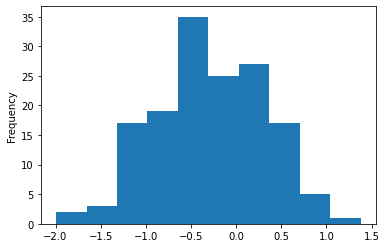

In [24]:
# distribution of proportional degree of cities
logged = np.log10(df_cities.fr_deg_prop)
logged.plot.hist()

In [25]:
df_cities['fr_log'] = logged

<AxesSubplot:ylabel='Frequency'>

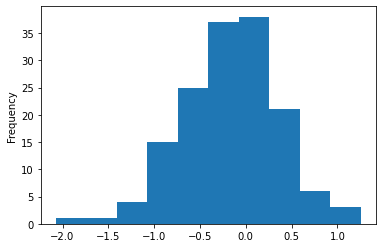

In [26]:
logged = np.log10(df_cities.en_deg_prop)
logged.plot.hist()

In [27]:
df_cities['en_log'] = logged

## Merge with Coordinates for mapping

In [28]:
fp = os.path.join(INDIR, "nodes.shp")
gdf = gpd.read_file(fp)

In [29]:
gdf.head()

,Mua_en,POP,CC,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM,geometry
0,Utrecht,390,NL,1,0,0,0,west,0,0,POINT (5.11148 52.09863)
1,Eindhoven,316,NL,1,0,0,0,west,0,0,POINT (5.47234 51.45709)
2,Amsterdam,1052,NL,1,0,0,0,west,0,0,POINT (4.87429 52.37074)
3,Rotterdam,1025,NL,1,0,0,0,west,0,0,POINT (4.47374 51.92364)
4,Poznan,679,PL,0,0,0,1,central_east,0,0,POINT (16.91751 52.40734)


In [30]:
# gdf = gdf[['Mua_en', 'POP', 'CC', 'EN_DUM', 'FR_DUM', 'geometry']].copy()
# gdf.head()

In [31]:
gdf['Mua_en'] = [unidecode.unidecode(city) for city in gdf['Mua_en']]

In [32]:
gdf = pd.merge(gdf, df_cities, how='left', left_on = 'Mua_en', right_on = 'city')

In [33]:
gdf.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [34]:
gdf.head()

,Mua_en,POP,CC,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM,geometry,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop,fr_log,en_log
0,Utrecht,390,NL,1,0,0,0,west,0,0,POINT (5.11148 52.09863),Utrecht,6207.0,3106.0,0.594711,0.517205,-0.286337,-0.225694
1,Eindhoven,316,NL,1,0,0,0,west,0,0,POINT (5.47234 51.45709),Eindhoven,2958.0,1579.0,0.283415,0.262932,-0.580157,-0.547577
2,Amsterdam,1052,NL,1,0,0,0,west,0,0,POINT (4.87429 52.37074),Amsterdam,31842.0,15898.0,3.050878,2.647304,0.422804,0.484425
3,Rotterdam,1025,NL,1,0,0,0,west,0,0,POINT (4.47374 51.92364),Rotterdam,11230.0,5341.0,1.075980,0.889373,-0.050916,0.031804
4,Poznan,679,PL,0,0,0,1,central_east,0,0,POINT (16.91751 52.40734),Poznan,6032.0,1906.0,0.577944,0.317383,-0.498416,-0.238114


In [34]:
# save to .shp file
fp = os.path.join(OUTDIR, "nodes.shp")
gdf.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/15/8v892gvj639_bp8s5ftm80400000gn/T/ipykernel_11702/3049174757.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(fp)


In [35]:
# save as dataframe
df = gdf.copy()
df.drop(['geometry'], axis = 1, inplace = True)

In [36]:
df

,Mua_en,POP,CC,WEST,SOUTH,NORTH,CEAST,REGION,EN_DUM,FR_DUM,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop,fr_log,en_log
0,Utrecht,390,NL,1,0,0,0,west,0,0,Utrecht,6207.0,3106.0,0.594711,0.517205,-0.286337,-0.225694
1,Eindhoven,316,NL,1,0,0,0,west,0,0,Eindhoven,2958.0,1579.0,0.283415,0.262932,-0.580157,-0.547577
2,Amsterdam,1052,NL,1,0,0,0,west,0,0,Amsterdam,31842.0,15898.0,3.050878,2.647304,0.422804,0.484425
3,Rotterdam,1025,NL,1,0,0,0,west,0,0,Rotterdam,11230.0,5341.0,1.075980,0.889373,-0.050916,0.031804
4,Poznan,679,PL,0,0,0,1,central_east,0,0,Poznan,6032.0,1906.0,0.577944,0.317383,-0.498416,-0.238114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Kaunas,379,LT,0,0,1,0,north,0,0,Kaunas,2076.0,603.0,0.198908,0.100410,-0.998221,-0.701348
147,Vilnius,554,LT,0,0,1,0,north,0,0,Vilnius,4328.0,1441.0,0.414679,0.239953,-0.619875,-0.382288
148,Riga,764,LV,0,0,1,0,north,0,0,Riga,4918.0,1835.0,0.471208,0.305561,-0.514903,-0.326787
149,Berlin,3776,DE,1,0,0,0,west,0,0,Berlin,86900.0,38242.0,8.326151,6.367983,0.804002,0.920444


In [37]:
fp = os.path.join(OUTDIR, "nodes.csv")
df.to_csv(fp, index = False, sep=';') 

<div class="alert alert-block alert-warning">
<b> R notebook in between this)</b> 
</div>

In [35]:
df_cities.head()

,city,en_degree,fr_degree,en_deg_prop,fr_deg_prop,fr_log,en_log
0,Paris,133309.0,143169.0,12.772737,23.840223,1.377310,1.106284
1,London,186465.0,49256.0,17.865773,8.202013,0.913920,1.252022
2,Madrid,40176.0,22625.0,3.849383,3.767471,0.576050,0.585391
3,Berlin,86900.0,38242.0,8.326151,6.367983,0.804002,0.920444
4,Milan,40714.0,26289.0,3.900931,4.377593,0.641235,0.591168


In [74]:
fp = os.path.join(OUTDIR, "edges_nz.csv")
df_new = pd.read_csv(fp, sep=';')

In [75]:
df_new.head()

,city_A,city_B,POP_A,POP_B,CC_A,CC_B,distance,border_DUM,reg_border,FR_con,...,en_fr_prop,log10fren,lang,lang_int,res_en2,res_fr2,pred_en2,pred_fr2,pred_en2_exp,pred_fr2_exp
0,Paris,London,9591,8256,FR,UK,342.719841,1,0,1,...,1.172655,-0.069170,BOTH,OTHER,0.935661,1.138099,9.057393,8.142979,8581.745601,3439.148052
1,Paris,Madrid,9591,4955,FR,ES,1047.105521,1,1,1,...,0.812345,0.090259,FR,OTHER,0.545147,1.127986,7.584617,6.656904,1967.693075,778.137758
2,Paris,Berlin,9591,3776,FR,DE,879.835916,1,0,1,...,0.962315,0.016683,FR,OTHER,1.615544,2.009756,7.358948,6.450443,1570.183558,632.982680
3,Paris,Milan,9591,3698,FR,IT,640.685161,1,1,1,...,0.708794,0.149480,FR,OTHER,0.552024,1.240146,7.562301,6.665664,1924.267515,784.984794
4,Paris,Barcelona,9591,3659,FR,ES,827.813778,1,1,1,...,0.813215,0.089795,FR,OTHER,0.419540,0.978479,7.362434,6.457549,1575.666582,637.496707


In [76]:
# log degree
en_degrees = dict()

for city in cities: 
    en_degrees[city] = 0

fr_degrees = en_degrees.copy()

for i, row in df_new.iterrows():
    en_degrees[row.city_A] += row.pred_en2_exp
    en_degrees[row.city_B] += row.pred_en2_exp
    fr_degrees[row.city_A] += row.pred_fr2_exp
    fr_degrees[row.city_B] += row.pred_fr2_exp

In [77]:
df_cities['fr_pred_exp'] = fr_degrees.values()
df_cities['en_pred_exp'] = en_degrees.values()

In [54]:
# residuals
en_degrees = dict()

for city in cities: 
    en_degrees[city] = 0
    
fr_degrees = en_degrees.copy()

In [55]:
for i, row in df_new.iterrows():
    en_degrees[row.city_A] += row.pred_en2
    en_degrees[row.city_B] += row.pred_en2
    fr_degrees[row.city_A] += row.pred_fr2
    fr_degrees[row.city_B] += row.pred_fr2

In [56]:
df_cities['fr_pred'] = fr_degrees.values()
df_cities['en_pred'] = en_degrees.values()

In [57]:
# residuals
en_degrees = dict()

for city in cities: 
    en_degrees[city] = 0
    
fr_degrees = en_degrees.copy()

In [58]:
for i, row in df_new.iterrows():
    en_degrees[row.city_A] += row.res_en2
    en_degrees[row.city_B] += row.res_en2
    fr_degrees[row.city_A] += row.res_fr2
    fr_degrees[row.city_B] += row.res_fr2

In [59]:
df_cities['fr_res'] = fr_degrees.values()
df_cities['en_res'] = en_degrees.values()

In [60]:
df_cities[['city','en_degree','fr_degree','en_res','fr_res']].sort_values('en_res', ascending=True).head(15)

,city,en_degree,fr_degree,en_res,fr_res
11,Katowice,2410.0,732.0,-174.970657,-185.959607
47,Bochum-Herne,3533.0,1100.0,-153.697651,-155.873645
61,Gelsenkirchen-Bottrop,1382.0,453.0,-149.399945,-143.358783
51,Duisburg,3653.0,829.0,-125.962653,-143.133951
39,Essen-Oberhausen,6671.0,2226.0,-122.947294,-133.302628
72,Saarbrucken,2281.0,1104.0,-111.342348,-104.521151
40,Lille,6743.0,19111.0,-101.297809,-7.105723
41,Lodz,4435.0,1578.0,-97.105319,-111.600597
114,Lens,1457.0,3689.0,-93.843686,-1.383937
140,Charleroi,1309.0,3076.0,-90.638355,8.586437


In [67]:
# verschil percentage groter kleiner
def estimation(row, pred_col, res_col):
    percentage = (row[res_col] / row[pred_col]) * 100
    
    return round(percentage, 2)

In [68]:
df_cities['fr_estimation'] = df_cities.apply(estimation, pred_col = 'fr_pred', res_col = 'fr_res', axis = 1)
df_cities['en_estimation'] = df_cities.apply(estimation, pred_col = 'en_pred', res_col = 'en_res', axis = 1)

In [73]:
df_cities[['city','en_pred','fr_pred','en_res','fr_res','fr_estimation', 'en_estimation']].sort_values('fr_estimation', ascending=True).head(15)

,city,en_pred,fr_pred,en_res,fr_res,fr_estimation,en_estimation
137,Busto Arsizio,37.082886,29.200033,-27.200418,-21.915212,-75.05,-73.35
61,Gelsenkirchen-Bottrop,268.851720,216.700212,-149.399945,-143.358783,-66.16,-55.57
11,Katowice,349.723997,287.761829,-174.970657,-185.959607,-64.62,-50.03
120,Castellammare di Stabia-Torre Annunziata,55.409520,42.788507,-35.716614,-27.049788,-63.22,-64.46
118,Las Palmas,74.894463,48.250903,12.228059,-29.547223,-61.24,16.33
104,Wuppertal,234.219352,182.403369,-85.545929,-99.208532,-54.39,-36.52
51,Duisburg,333.385294,269.224736,-125.962653,-143.133951,-53.17,-37.78
94,Bielefeld,253.871667,194.637994,-77.489561,-102.092487,-52.45,-30.52
47,Bochum-Herne,381.329922,307.005568,-153.697651,-155.873645,-50.77,-40.31
106,Bournemouth,211.916206,160.344725,-15.199802,-77.189548,-48.14,-7.17


In [81]:
# verschil percentage groter kleiner
def estimation2(row, pred_col, degree_col):
    residual = row[degree_col] - row[pred_col]
    percentage = (residual / row[pred_col]) * 100
    
    return round(percentage, 2)

In [82]:
df_cities['fr_estimation_e'] = df_cities.apply(estimation2, pred_col = 'fr_pred_exp', degree_col = 'fr_degree', axis = 1)
df_cities['en_estimation_e'] = df_cities.apply(estimation2, pred_col = 'en_pred_exp', degree_col = 'en_degree', axis = 1)

In [83]:
df_cities[['city','en_pred_exp','fr_pred_exp','fr_estimation_e', 'en_estimation_e']].sort_values('fr_estimation_e', ascending=True).head(15)


,city,en_pred_exp,fr_pred_exp,fr_estimation_e,en_estimation_e
61,Gelsenkirchen-Bottrop,18413.251796,6526.245990,-93.06,-92.49
137,Busto Arsizio,2637.441068,869.067792,-92.98,-96.63
11,Katowice,16796.596851,6265.616413,-88.32,-85.65
51,Duisburg,18049.069378,6393.283082,-87.03,-79.76
47,Bochum-Herne,21958.407022,7819.425707,-85.93,-83.91
120,Castellammare di Stabia-Torre Annunziata,2897.925540,970.120218,-84.95,-92.96
104,Wuppertal,8203.781804,2954.820307,-82.74,-77.66
39,Essen-Oberhausen,27570.471778,9771.902297,-77.22,-75.80
8,Birmingham,45037.186810,14359.236264,-74.94,-25.73
94,Bielefeld,5689.218763,2031.134084,-74.05,-61.86


<AxesSubplot:ylabel='Frequency'>

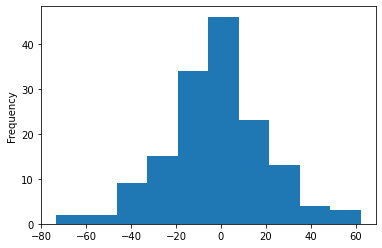

In [65]:
df_cities.en_estimation.plot.hist()